In [1]:
# Figures for INCITE proposal
%pwd

'/global/u2/c/crjones/sp-analysis/e3sm_analysis_and_plots'

In [2]:
%matplotlib inline
import xarray as xr
import numpy as np
import cartopy.crs as ccrs   # map plots
from e3sm_utils import cmclimate
cmap_prect = cmclimate.cm.WhiteBlueGreenYellowRed
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from glob import glob

In [10]:
from concurrent.futures import ProcessPoolExecutor

In [11]:
ds1 = xr.open_mfdataset('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/monthly/mcs_rainmap_*.nc')
ds2 = xr.open_mfdataset('/global/cscratch1/sd/crjones/ECP/e3sm/statstb/monthly/mcs_rainmap_*.nc')
dsx = xr.concat([ds1, ds2], dim=pd.Index(('MMF', 'E3SM'), name='model'))

# MCS precipitation map

In [4]:
# prepare figure canvas:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

In [5]:
def regional_mean(da, ax, lons=(256, 275), lats=(32, 48), text_loc=[257, 47], units=''):
    xy = [lons[0], lats[0]]
    width = lons[1] - lons[0]
    height = lats[1] - lats[0]
    ax.add_patch(mpatches.Rectangle(xy=xy, width=width, height=height,
                                    facecolor='none', edgecolor='magenta',
                                    alpha=1, linewidth=2,
                                    transform=ccrs.PlateCarree()))
    model = ax.get_title().split("=")[-1].strip()
    mn = da.sel(model=model).sel(lon=slice(*lons), lat=slice(*lats)).mean().values.item()
    ax.text(text_loc[0], text_loc[1], 'Mean: {:0.1f} '.format(mn) + units, color='magenta', transform=ccrs.PlateCarree())

In [18]:
seas = dsx.groupby('time.season').mean(dim='time')

In [16]:
mjja = dsx.groupby('time.month').mean(dim='time').sel(month=slice(5, 8)).mean(dim='month')
mjja_central = mjja.sel(lat=slice(29, 50), lon=slice(255, 278))

In [17]:
# total accumulated precipitation in mm. To convert, need to divide by number of samples ...
# mjja samples is mean over months ... this should be done better
ndays_mmf = 122
fac = 4 / ndays_mmf  # x 4 months / 122 days
da = mjja_central.mcs_precipitation * fac # units = mm
da.attrs['units'] = 'mm / day'
units = 'mm d$^{-1}$'

In [15]:
da.lon.values

array([255.125, 255.375, 255.625, 255.875, 256.125, 256.375, 256.625,
       256.875, 257.125, 257.375, 257.625, 257.875, 258.125, 258.375,
       258.625, 258.875, 259.125, 259.375, 259.625, 259.875, 260.125,
       260.375, 260.625, 260.875, 261.125, 261.375, 261.625, 261.875,
       262.125, 262.375, 262.625, 262.875, 263.125, 263.375, 263.625,
       263.875, 264.125, 264.375, 264.625, 264.875, 265.125, 265.375,
       265.625, 265.875, 266.125, 266.375, 266.625, 266.875, 267.125,
       267.375, 267.625, 267.875, 268.125, 268.375, 268.625, 268.875,
       269.125, 269.375, 269.625, 269.875, 270.125, 270.375, 270.625,
       270.875, 271.125, 271.375, 271.625, 271.875, 272.125, 272.375,
       272.625, 272.875, 273.125, 273.375, 273.625, 273.875, 274.125,
       274.375, 274.625, 274.875, 275.125, 275.375, 275.625, 275.875,
       276.125, 276.375, 276.625, 276.875, 277.125, 277.375, 277.625,
       277.875], dtype=float32)

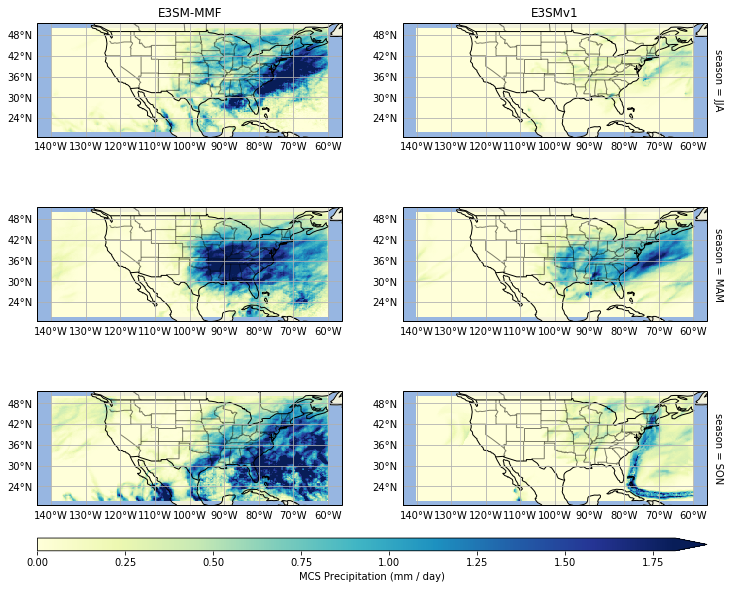

In [36]:
# note: season values = avg amount accumulated per month!
#       appropriate scaling is "mm / month -> mm per day"
ndays_per_season = [3 / (31+30+31), 3 / (30+31+31), 2 / (30+31)]
da_ndays = xr.DataArray(ndays_per_season, [('season', ['MAM', 'JJA', 'SON'])])
da = seas.mcs_precipitation * da_ndays
da.attrs['units'] = 'mm / day'
units = 'mm d$^{-1}$'

levels = np.arange(0, 1.3, 0.1)
p = da.plot(x='lon', y='lat', col='model', row='season', figsize=(12, 12),
            subplot_kws={'projection': ccrs.PlateCarree()}, 
            transform=ccrs.PlateCarree(), cmap=plt.cm.YlGnBu,    # cmap=cmap_prect,
            # levels=levels,
            robust=True, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50, 
                                      'label': 'MCS Precipitation (mm / day)'})
ax_titles = ['E3SM-MMF', 'E3SMv1']
for i, ax in enumerate(p.axes.flat):
    ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
    ax.coastlines()
    # ax.set_extent([255.125 - 360, 277.875 - 360, 29.125, 49.875])
    # format gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    # regional_mean(da, ax, units=units)
    if i < 2:
        ax.set_title(ax_titles[i])

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


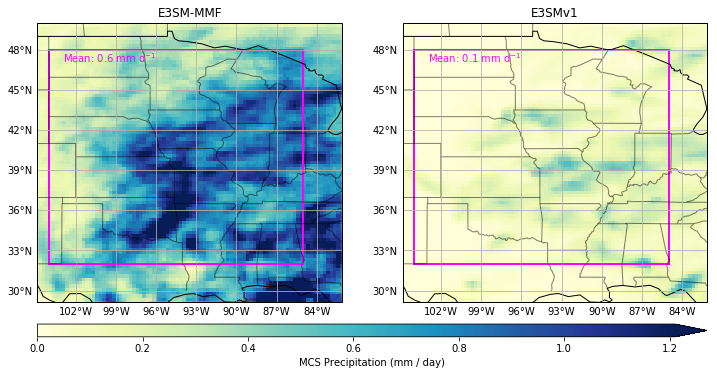

In [18]:
levels = np.arange(0, 1.3, 0.1)
p = da.plot(x='lon', y='lat', col='model', figsize=(12, 8),
            subplot_kws={'projection': ccrs.PlateCarree()}, 
            transform=ccrs.PlateCarree(), cmap=plt.cm.YlGnBu,    # cmap=cmap_prect,
            # levels=levels,
            robust=True, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50, 
                                      'label': 'MCS Precipitation (mm / day)'})
ax_titles = ['E3SM-MMF', 'E3SMv1']
for ax, ax_title in zip(p.axes.flat, ax_titles):
    ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
    ax.coastlines()
    ax.set_extent([255.125 - 360, 277.875 - 360, 29.125, 49.875])
    # format gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    regional_mean(da, ax, units=units)
    ax.set_title(ax_title)

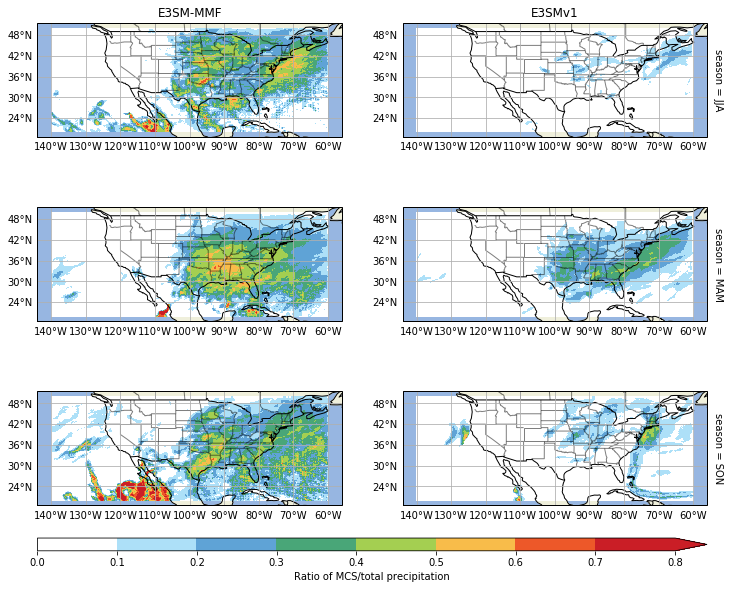

In [33]:
# precipitation ratio
# da = mjja_central.mcs_precipitation / mjja_central.precipitation
# units = ''
da = seas.mcs_precipitation / seas.precipitation
units = ''
levels = np.arange(0, 0.9, 0.1)
p = da.plot(x='lon', y='lat', col='model', row='season', figsize=(12, 12),
            subplot_kws={'projection': ccrs.PlateCarree()}, 
            transform=ccrs.PlateCarree(), cmap=cmap_prect,
            levels=levels,
            robust=False, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50,
                                       'label': 'Ratio of MCS/total precipitation', 'ticks': levels})
ax_titles = ['E3SM-MMF', 'E3SMv1']
for i, ax in enumerate(p.axes.flat):
    ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
    ax.coastlines()
    # ax.set_extent([255.125 - 360, 277.875 - 360, 29.125, 49.875])
    # format gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    # regional_mean(da, ax, units=units, text_loc=[256, 49])
    # regional_mean(da, ax, units=units)
    if i < 2:
        ax.set_title(ax_titles[i])

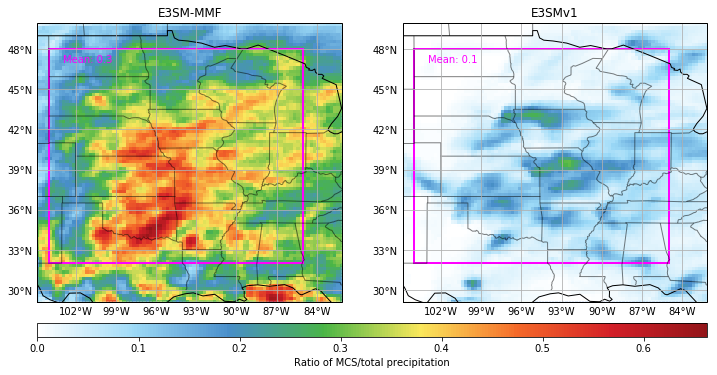

In [19]:
# precipitation ratio
da = mjja_central.mcs_precipitation / mjja_central.precipitation
units = ''
# levels = np.arange(0, 0.8, 0.1)
p = da.plot(x='lon', y='lat', col='model', figsize=(12, 8),
            subplot_kws={'projection': ccrs.PlateCarree()}, 
            transform=ccrs.PlateCarree(), cmap=cmap_prect,
            robust=False, cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'aspect': 50,
                                       'label': 'Ratio of MCS/total precipitation'})
ax_titles = ['E3SM-MMF', 'E3SMv1']
for ax, ax_title in zip(p.axes.flat, ax_titles):
    ax.add_feature(states_provinces, edgecolor='black', alpha=0.5)
    ax.coastlines()
    ax.set_extent([255.125 - 360, 277.875 - 360, 29.125, 49.875])
    # format gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
    ax.add_feature(cfeature.LAND)
    # regional_mean(da, ax, units=units, text_loc=[256, 49])
    regional_mean(da, ax, units=units)
    ax.set_title(ax_title)

# MCS Hovmollers

In [20]:
from dask.distributed import Client, LocalCluster, progress

In [21]:
cluster = LocalCluster(n_workers=4)

In [22]:
# reminder: dask arrays don't support assignment, so 
#           prec_mcs.values[non_mcs] = 0 does nothing if prec_mcs is a dask array :(
def process_hovmoller(pat, region={'lat': slice(31, 48), 'lon': slice(255, 275)}):
    ds = xr.open_mfdataset(pat, parallel=True).sel(**region)  # total 
    non_mcs = np.isnan(ds['pcptracknumber'].values)  # spots where there are no mcses
    # prec_tot = ds['precipitation'].mean(dim='lat').groupby('time.hour').mean(dim='time').compute()
    prec_mcs = ds['precipitation'].copy(deep=True).load()
    prec_mcs.values[non_mcs] = 0
    prec_mcs_hrly = prec_mcs.mean(dim='lat').groupby('time.hour').mean(dim='time')
    return prec_mcs_hrly

In [23]:
def process_from_robust_stats(robust_mcs_filename,
                              topdir='/global/cscratch1/sd/crjones/ECP/e3sm-mmf', nmax=None):
    date_range = robust_mcs_filename[-20:-3]  # 200n0301_200n1031
    pat = date_range[0:4] + '0[5-8]*.nc'
    pixel_files = sorted(glob('{}/mcstracking/{}/mcstrack_{}'.format(topdir, date_range, pat)))
    print([pixel_files[j] for j in [0, 1, -2, -1]])
    return process_hovmoller(pixel_files)

In [11]:
robust_mcs_files = sorted(glob('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks*.nc'))
robust_mcs_files

['/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20010301_20011031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20020301_20021031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20030301_20031031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20040301_20041031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20050301_20051031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20060301_20061031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20070301_20071031.nc']

In [25]:
# results_dict = {}
with Client(cluster) as client:
    for fname in robust_mcs_files[5:]:
        date_range = fname[-20:-3]  # 200n0301_200n1031
        print(fname)
        print(date_range)
        results_dict[date_range] = process_from_robust_stats(fname)

/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20060301_20061031.nc
20060301_20061031
['/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20060301_20061031/mcstrack_20060501_0000.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20060301_20061031/mcstrack_20060501_0100.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20060301_20061031/mcstrack_20060831_2200.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20060301_20061031/mcstrack_20060831_2300.nc']
/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20070301_20071031.nc
20070301_20071031
['/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20070301_20071031/mcstrack_20070501_0000.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20070301_20071031/mcstrack_20070501_0100.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20070301_20071031/mcstrack_20070831_2200.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20070301_20071031/mcst

In [24]:
# now e3sm ...
results_e3sm = {}
robust_mcs_files = sorted(glob('/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_*.nc'))
with Client(cluster) as client:
    for fname in robust_mcs_files:
        date_range = fname[-20:-3]  # 200n0301_200n1031
        print(fname)
        print(date_range)
        results_e3sm[date_range] = process_from_robust_stats(fname,
                                                             topdir='/global/cscratch1/sd/crjones/ECP/e3sm')

/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20010301_20011031.nc
20010301_20011031
['/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010501_0000.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010501_0100.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010831_2200.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010831_2300.nc']
/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20020301_20021031.nc
20020301_20021031
['/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20020301_20021031/mcstrack_20020501_0000.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20020301_20021031/mcstrack_20020501_0100.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20020301_20021031/mcstrack_20020831_2200.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20020301_20021031/mcstrack_20020831_2300.nc']
/global/cscratch

In [25]:
keys = sorted([k for k in results_e3sm.keys()])
da_e3sm = xr.concat([results_e3sm[k] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))
da_e3sm

<xarray.DataArray 'precipitation' (year: 3, hour: 24, lon: 80)>
array([[[0.000000e+00, 0.000000e+00, ..., 5.066724e-03, 4.758707e-03],
        [0.000000e+00, 0.000000e+00, ..., 4.137553e-03, 3.630407e-03],
        ...,
        [0.000000e+00, 0.000000e+00, ..., 9.175518e-03, 8.618529e-03],
        [0.000000e+00, 0.000000e+00, ..., 9.097959e-03, 1.023603e-02]],

       [[1.298118e-04, 6.342882e-05, ..., 3.972442e-04, 7.680734e-04],
        [0.000000e+00, 0.000000e+00, ..., 2.421539e-04, 2.353840e-04],
        ...,
        [5.781681e-04, 6.988793e-04, ..., 1.924552e-03, 1.912732e-03],
        [3.473182e-04, 2.966146e-04, ..., 1.814527e-03, 1.946801e-03]],

       [[6.496279e-03, 4.745482e-03, ..., 1.848735e-02, 1.816159e-02],
        [6.763278e-03, 5.954633e-03, ..., 1.871882e-02, 1.847658e-02],
        ...,
        [2.274804e-03, 1.221282e-03, ..., 4.147012e-03, 3.549861e-03],
        [4.901620e-03, 2.631419e-03, ..., 1.167166e-02, 7.615363e-03]]],
      dtype=float32)
Coordinates:
  * l

In [26]:
da_e3sm.attrs = {'units': 'mm / hr'}
da_e3sm.to_netcdf('/global/homes/c/crjones/sp-analysis/mcs_hov_e3sm_2001-2003.nc')

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:59661 remote=tcp://127.0.0.1:43005>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:59707 remote=tcp://127.0.0.1:43005>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:59709 remote=tcp://127.0.0.1:43005>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:59713 remote=tcp://127.0.0.1:43005>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:59723 remote=tcp://127.0.0.1:43005>


In [26]:
keys = sorted([k for k in results_dict.keys()])
da_hov = xr.concat([results_dict[k] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))
da_hov

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34035 remote=tcp://127.0.0.1:42049>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34175 remote=tcp://127.0.0.1:42049>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34183 remote=tcp://127.0.0.1:42049>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:34457 remote=tcp://127.0.0.1:42049>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:55101 remote=tcp://127.0.0.1:42049>


<xarray.DataArray 'precipitation' (year: 7, hour: 24, lon: 80)>
array([[[0.001249, 0.001856, ..., 0.033636, 0.029695],
        [0.00068 , 0.000818, ..., 0.034118, 0.033095],
        ...,
        [0.001753, 0.001964, ..., 0.02418 , 0.022801],
        [0.002121, 0.002129, ..., 0.029471, 0.029658]],

       [[0.001403, 0.002426, ..., 0.054598, 0.048936],
        [0.003564, 0.003622, ..., 0.07041 , 0.060583],
        ...,
        [0.0014  , 0.002176, ..., 0.041405, 0.03407 ],
        [0.001911, 0.002409, ..., 0.049644, 0.048222]],

       ...,

       [[0.023799, 0.021121, ..., 0.034298, 0.03952 ],
        [0.028024, 0.026757, ..., 0.03009 , 0.031992],
        ...,
        [0.015585, 0.014724, ..., 0.029156, 0.035148],
        [0.019337, 0.016059, ..., 0.03267 , 0.035997]],

       [[0.004792, 0.005009, ..., 0.022589, 0.022966],
        [0.015272, 0.013073, ..., 0.022292, 0.019249],
        ...,
        [0.006152, 0.003889, ..., 0.025285, 0.023131],
        [0.006418, 0.005537, ..., 0.0200

In [27]:
da_hov.attrs = {'units': 'mm / hr'}
da_hov.to_netcdf('/global/homes/c/crjones/sp-analysis/mcs_hov_e3sm-mmf_2001-2007.nc')

In [29]:
da_hov = xr.open_dataarray('/global/homes/c/crjones/sp-analysis/mcs_hov_e3sm-mmf_2001-2007.nc')
da_hov

<xarray.DataArray 'precipitation' (year: 7, hour: 24, lon: 80)>
array([[[0.001249, 0.001856, ..., 0.033636, 0.029695],
        [0.00068 , 0.000818, ..., 0.034118, 0.033095],
        ...,
        [0.001753, 0.001964, ..., 0.02418 , 0.022801],
        [0.002121, 0.002129, ..., 0.029471, 0.029658]],

       [[0.001403, 0.002426, ..., 0.054598, 0.048936],
        [0.003564, 0.003622, ..., 0.07041 , 0.060583],
        ...,
        [0.0014  , 0.002176, ..., 0.041405, 0.03407 ],
        [0.001911, 0.002409, ..., 0.049644, 0.048222]],

       ...,

       [[0.023799, 0.021121, ..., 0.034298, 0.03952 ],
        [0.028024, 0.026757, ..., 0.03009 , 0.031992],
        ...,
        [0.015585, 0.014724, ..., 0.029156, 0.035148],
        [0.019337, 0.016059, ..., 0.03267 , 0.035997]],

       [[0.004792, 0.005009, ..., 0.022589, 0.022966],
        [0.015272, 0.013073, ..., 0.022292, 0.019249],
        ...,
        [0.006152, 0.003889, ..., 0.025285, 0.023131],
        [0.006418, 0.005537, ..., 0.0200

In [ ]:
keys = sorted([k for k in results_dict.keys()])
da_hov = xr.concat([results_dict[k] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))

In [30]:
da = da_hov.mean(dim='year') * 24
# need to shuffle the time to plot from 12:00 to 12:00 with 24:00 in middle
utc_offset = -6
dat = da.values  # numpy array, shape = (local_time, lon)
np.vstack(np.vsplit(dat,[24 + utc_offset])[::-1])
local_time = da.hour - 12  # hour from -12 to 24 (aka 0) to 12

([<matplotlib.axis.XTick at 0x2aad52b586d8>,
 <a list of 5 Text xticklabel objects>)

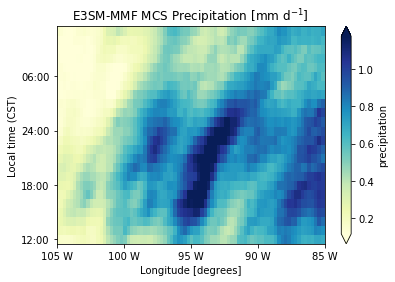

In [31]:
p = da.assign_coords(hour=local_time).plot(x='lon', y='hour', cmap=plt.cm.YlGnBu, robust=True)
p.axes.set_title('E3SM-MMF MCS Precipitation [mm d$^{-1}$]');
plt.yticks(ticks=[-12, -6, 0, 6], labels=['12:00', '18:00', '24:00', '06:00']);
p.axes.set_ylabel('Local time (CST)')
plt.xticks(ticks=[255, 260, 265, 270, 275], labels=['105 W', '100 W', '95 W', '90 W', '85 W'])

In [27]:
da2 = da_e3sm.mean(dim='year') * 24
# need to shuffle the time to plot from 12:00 to 12:00 with 24:00 in middle
utc_offset = -6
dat = da2.values  # numpy array, shape = (local_time, lon)
np.vstack(np.vsplit(dat,[24 + utc_offset])[::-1])
local_time = da2.hour - 12  # hour from -12 to 24 (aka 0) to 12

([<matplotlib.axis.XTick at 0x2aad5335cc88>,
 <a list of 5 Text xticklabel objects>)

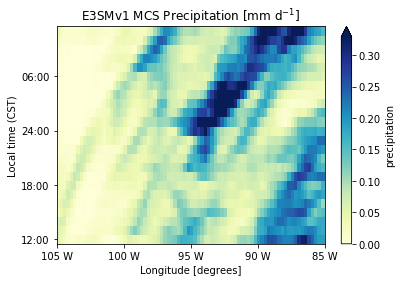

In [28]:
p = da2.assign_coords(hour=local_time).plot(x='lon', y='hour', cmap=plt.cm.YlGnBu, robust=True)
p.axes.set_title('E3SMv1 MCS Precipitation [mm d$^{-1}$]');
plt.yticks(ticks=[-12, -6, 0, 6], labels=['12:00', '18:00', '24:00', '06:00']);
p.axes.set_ylabel('Local time (CST)')
plt.xticks(ticks=[255, 260, 265, 270, 275], labels=['105 W', '100 W', '95 W', '90 W', '85 W'])

In [32]:
ds = xr.concat([da, da2], dim=pd.Index(['E3SM-MMF', 'E3SMv1'], name='model'))

Text(0.5, 1.05, 'Mean Diurnal Cycle of Central US Warm-season MCS Precipitation')

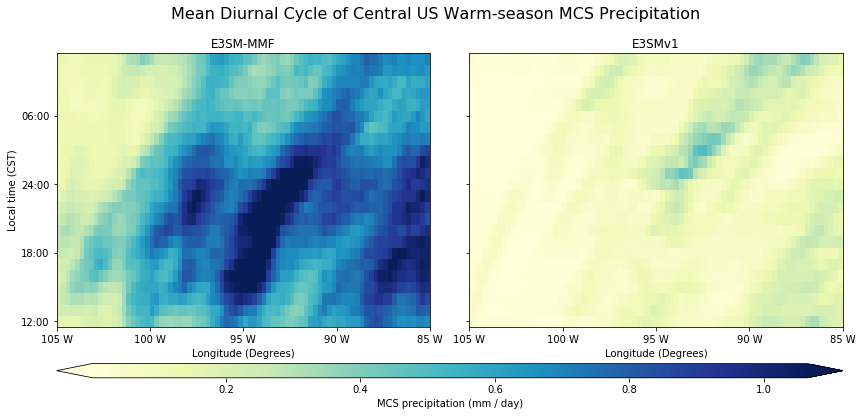

In [33]:
p = ds.assign_coords(hour=local_time).plot(x='lon', y='hour', col='model', cmap=plt.cm.YlGnBu, robust=True, figsize=(12, 6), 
                                       cbar_kwargs={'orientation': 'horizontal', 'pad': 0.1, 'aspect': 50,
                                                    'label': 'MCS precipitation (mm / day)'})
models = ['E3SM-MMF', 'E3SMv1']
for i, ax in enumerate(p.axes.flat):
    ax.set_title(models[i])
    if i == 0:
        plt.yticks(ticks=[-12, -6, 0, 6], labels=['12:00', '18:00', '24:00', '06:00']);
        ax.set_ylabel('Local time (CST)')
    else:
        plt.yticks(ticks=[-12, -6, 0, 6]);
    plt.xticks(ticks=[255, 260, 265, 270, 275], labels=['105 W', '100 W', '95 W', '90 W', '85 W'])
    ax.set_xlabel('Longitude (Degrees)')
p.fig.suptitle('Mean Diurnal Cycle of Central US Warm-season MCS Precipitation', y=1.05, fontsize=16)

In [ ]:
# need to shuffle the time to plot from 12:00 to 12:00 with 24:00 in middle
utc_offset = -6
dat = da.values  # numpy array, shape = (local_time, lon)
np.vstack(np.vsplit(dat,[24 + utc_offset])[::-1])
local_time = da.hour - 12  # hour from -12 to 24 (aka 0) to 12

# OMEGA500

In [3]:
ds_mmf = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science/monthly_hist/clim_rgr/0002-0007/earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m_[DMJS]??_climo.nc',
                           concat_dim='time')
ds_e3sm = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science_e3sm/clim_rgr/0001-0001/earlyscience.FC5AV1C-H01A.ne120.E3SM.20190329_[DMJS]??_climo.nc',
                            concat_dim='time')

In [ ]:
def preprocess_fun(ds):
    return name[:-9]

In [5]:
ds_e3sm.time

<xarray.DataArray 'time' (time: 4)>
array([cftime.DatetimeNoLeap(1, 6, 1, 16, 0, 0, 0, 5, 152),
       cftime.DatetimeNoLeap(1, 8, 1, 0, 0, 0, 0, 3, 213),
       cftime.DatetimeNoLeap(1, 5, 1, 8, 0, 0, 0, 2, 121),
       cftime.DatetimeNoLeap(1, 10, 31, 16, 0, 0, 0, 3, 304)], dtype=object)
Coordinates:
  * time     (time) object 0001-06-01 16:00:00 ... 0001-10-31 16:00:00
Attributes:
    long_name:     time
    climatology:   climatology_bounds
    cell_methods:  time: mean within years time: mean over years

In [6]:
ds = xr.open_dataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science/monthly_hist/clim_rgr/0002-0007/earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m_DJF_climo.nc')

In [8]:
ds_mmf.attrs

OrderedDict([('ne', 120),
             ('np', 4),
             ('Conventions', 'CF-1.0'),
             ('source', 'CAM'),
             ('case',
              'earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m.20190329'),
             ('title', 'UNSET'),
             ('logname', 'crjones'),
             ('host', ''),
             ('Version', '$Name$'),
             ('revision_Id', '$Id$'),
             ('initial_file',
              'earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m.20190327.cam.i.0001-11-01-00000.nc'),
             ('topography_file',
              '/gpfs/alpine/world-shared/csc190/e3sm/cesm/inputdata/atm/cam/topo/USGS-gtopo30_ne120np4_16xdel2-PFC-consistentSGH.nc'),
             ('time_period_freq', 'month_1'),
             ('history',
              "Wed May 15 09:55:15 2019: ncks -t 2 -O --no_tmp_fl --dfl_lvl=0 --hdr_pad=10000 --map /global/homes/z/zender/data/maps/map_ne120np4_to_cmip6_180x360_aave.20181001.nc /global/project/projectdirs/m3312/crjones/e3sm/early_science/m

# MCS Seasonal Hovmoller

In [8]:
from dask.distributed import Client, LocalCluster, progress

In [12]:
cluster = LocalCluster(n_workers=4)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:49846 remote=tcp://127.0.0.1:40923>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:49848 remote=tcp://127.0.0.1:40923>
/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/distributed/bokeh/core.py:56: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [3]:
central_us = {'lat': slice(31, 49), 'lon': slice(256, 279)}

In [13]:
# reminder: dask arrays don't support assignment, so 
#           prec_mcs.values[non_mcs] = 0 does nothing if prec_mcs is a dask array :(
def process_hovmoller(pat, region=central_us, mcs=True):
    ds = xr.open_mfdataset(pat, parallel=True).sel(**region)  # total 
    prec_mcs = ds['precipitation'].copy(deep=True).load()
    prec_tot_hrly = prec_mcs.mean(dim='lat').groupby('time.hour').mean(dim='time')
    if mcs:
        non_mcs = np.isnan(ds['pcptracknumber'].values)  # spots where there are no mcses
        prec_mcs.values[non_mcs] = 0
    prec_mcs_hrly = prec_mcs.mean(dim='lat').groupby('time.hour').mean(dim='time')
    return (prec_tot_hrly, prec_mcs_hrly)

In [7]:
def process_from_robust_stats(robust_mcs_filename,
                              topdir='/global/cscratch1/sd/crjones/ECP/e3sm-mmf',
                              season='MAM', mcs=True):
    date_range = robust_mcs_filename[-20:-3]  # 200n0301_200n1031
    if season == 'MAM':
        pat_suffix = '0[3-5]*.nc'
    elif season == 'JJA':
        pat_suffix = '0[6-8]*.nc'
    else:
        pat_suffix = season
    pat = date_range[0:4] + pat_suffix
    pixel_files = sorted(glob('{}/mcstracking/{}/mcstrack_{}'.format(topdir, date_range, pat)))
    print([pixel_files[j] for j in [0, 1, -2, -1]])
    return process_hovmoller(pixel_files)

In [10]:
robust_mcs_files = sorted(glob('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks*.nc'))
robust_mcs_files

['/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20010301_20011031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20020301_20021031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20030301_20031031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20040301_20041031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20050301_20051031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20060301_20061031.nc',
 '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20070301_20071031.nc']

In [14]:
results_dict_mam = {}
results_dict_jja = {}
with Client(cluster) as client:
    for fname in robust_mcs_files:
        date_range = fname[-20:-3]  # 200n0301_200n1031
        print(fname)
        print(date_range)
        results_dict_mam[date_range] = process_from_robust_stats(fname, season='MAM')
        results_dict_jja[date_range] = process_from_robust_stats(fname, season='JJA')

/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20010301_20011031.nc
20010301_20011031
['/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010301_0000.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010301_0100.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010531_2200.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010531_2300.nc']
['/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010601_0000.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010601_0100.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010831_2200.nc', '/global/cscratch1/sd/crjones/ECP/e3sm-mmf/mcstracking/20010301_20011031/mcstrack_20010831_2300.nc']
/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/robust_mcs_tracks_20020301_200210

In [15]:
results_e3sm_mam = {}
results_e3sm_jja = {}
robust_mcs_files = sorted(glob('/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_*.nc'))
with Client(cluster) as client:
    for fname in robust_mcs_files:
        date_range = fname[-20:-3]  # 200n0301_200n1031
        print(fname)
        print(date_range)
        results_e3sm_mam[date_range] = process_from_robust_stats(fname, 
                                                                 topdir='/global/cscratch1/sd/crjones/ECP/e3sm',
                                                                 season='MAM')
        results_e3sm_jja[date_range] = process_from_robust_stats(fname,
                                                                 topdir='/global/cscratch1/sd/crjones/ECP/e3sm',
                                                                 season='JJA')

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:49122 remote=tcp://127.0.0.1:44511>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:49188 remote=tcp://127.0.0.1:44511>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:49288 remote=tcp://127.0.0.1:44511>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50502 remote=tcp://127.0.0.1:44511>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:50506 remote=tcp://127.0.0.1:44511>


/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20010301_20011031.nc
20010301_20011031
['/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010301_0000.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010301_0100.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010531_2200.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010531_2300.nc']
['/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010601_0000.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010601_0100.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010831_2200.nc', '/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20010301_20011031/mcstrack_20010831_2300.nc']
/global/cscratch1/sd/crjones/ECP/e3sm/statstb/robust_mcs_tracks_20020301_20021031.nc
20020301_20021031
['/global/cscrat

In [17]:
# build up a dataArray
keys = sorted([k for k in results_dict_mam.keys()])
# tot is first, mcs_only is next
da_tot_mam = xr.concat([results_dict_mam[k][0] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))
da_tot_jja = xr.concat([results_dict_jja[k][0] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))
da_mcs_mam = xr.concat([results_dict_mam[k][1] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))
da_mcs_jja = xr.concat([results_dict_jja[k][1] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))

da_tot_mmf = xr.concat([da_tot_mam, da_tot_jja], pd.Index(['MAM', 'JJA'], name='season'))
da_mcs_mmf = xr.concat([da_mcs_mam, da_mcs_jja], pd.Index(['MAM', 'JJA'], name='season'))

keys = sorted([k for k in results_e3sm_jja.keys()])
da_tot_mam2 = xr.concat([results_e3sm_mam[k][0] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))
da_tot_jja2 = xr.concat([results_e3sm_jja[k][0] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))
da_mcs_mam2 = xr.concat([results_e3sm_mam[k][1] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))
da_mcs_jja2 = xr.concat([results_e3sm_jja[k][1] for k in keys], pd.Index([int(k[:4]) for k in keys], name='year'))

da_tot_e3sm = xr.concat([da_tot_mam2, da_tot_jja2], pd.Index(['MAM', 'JJA'], name='season'))
da_mcs_e3sm = xr.concat([da_mcs_mam2, da_mcs_jja2], pd.Index(['MAM', 'JJA'], name='season'))

In [22]:
# run these into a dataSet
da_tot = xr.concat([da_tot_mmf, da_tot_e3sm], pd.Index(['MMF', 'E3SMv1'], name='model'))
da_mcs = xr.concat([da_mcs_mmf, da_mcs_e3sm], pd.Index(['MMF', 'E3SMv1'], name='model'))

In [25]:
ds_hov = xr.Dataset({'precipitation': da_tot, 'mcs_precipitation': da_mcs})
ds_hov

<xarray.Dataset>
Dimensions:            (hour: 24, lon: 92, model: 2, season: 2, year: 7)
Coordinates:
  * year               (year) int64 2001 2002 2003 2004 2005 2006 2007
  * lon                (lon) float32 256.125 256.375 256.625 ... 278.625 278.875
  * hour               (hour) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * season             (season) object 'MAM' 'JJA'
  * model              (model) object 'MMF' 'E3SMv1'
Data variables:
    precipitation      (model, season, year, hour, lon) float32 0.050515264 ... nan
    mcs_precipitation  (model, season, year, hour, lon) float32 0.0029315206 ... nan

In [26]:
# write to file before I lose it ...
ds_hov['precipitation'].attrs = {'units': 'mm / hr'}
ds_hov['mcs_precipitation'].attrs = {'units': 'mm / hr'}
ds_hov.to_netcdf('/global/homes/c/crjones/sp-analysis/mcs_hov_earlysci.nc')

In [35]:
ds = ds_hov.mean(dim='year') * 24
ds['precipitation'].attrs = {'units': 'mm / day'}
ds['mcs_precipitation'].attrs = {'units': 'mm / day'}

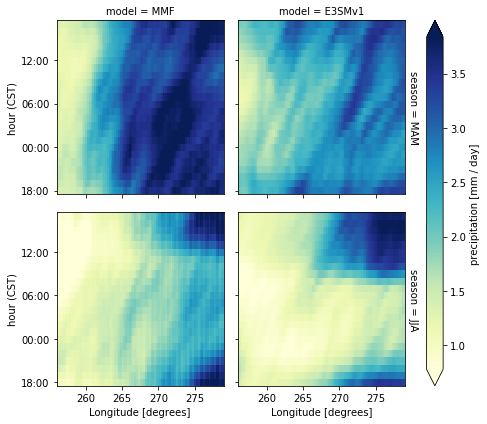

In [38]:
p = ds['precipitation'].plot(col='model', row='season', x='lon', y='hour', cmap=plt.cm.YlGnBu, robust=True)
for i, ax in enumerate(p.axes.flat):
    if i in [0, 2]:
        # ax.set_yticks(ticks=[0, 6, 12, 18], labels=['18:00', '00:00', '06:00', '12:00']);
        ax.set_yticks([0, 6, 12, 18])
        ax.set_yticklabels(['18:00', '00:00', '06:00', '12:00'])
        ax.set_ylabel('hour (CST)')
# p.fig.suptitle('Central US Total Precipitation')

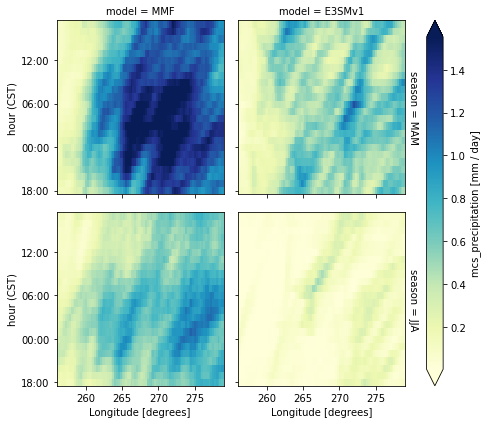

In [39]:
p = ds['mcs_precipitation'].plot(col='model', row='season', x='lon', y='hour', cmap=plt.cm.YlGnBu, robust=True)
for i, ax in enumerate(p.axes.flat):
    if i in [0, 2]:
        # ax.set_yticks(ticks=[0, 6, 12, 18], labels=['18:00', '00:00', '06:00', '12:00']);
        ax.set_yticks([0, 6, 12, 18])
        ax.set_yticklabels(['18:00', '00:00', '06:00', '12:00'])
        ax.set_ylabel('hour (CST)')
# p.fig.suptitle('Central US MCS Precipitation')

In [30]:
da = da_hov.mean(dim='year') * 24
# need to shuffle the time to plot from 12:00 to 12:00 with 24:00 in middle
utc_offset = -6
dat = da.values  # numpy array, shape = (local_time, lon)
np.vstack(np.vsplit(dat,[24 + utc_offset])[::-1])
local_time = da.hour - 12  # hour from -12 to 24 (aka 0) to 12

([<matplotlib.axis.XTick at 0x2aad52b586d8>,
 <a list of 5 Text xticklabel objects>)

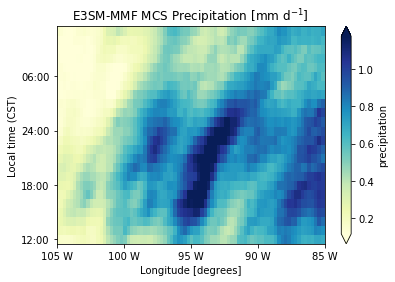

In [31]:
p = da.assign_coords(hour=local_time).plot(x='lon', y='hour', cmap=plt.cm.YlGnBu, robust=True)
p.axes.set_title('E3SM-MMF MCS Precipitation [mm d$^{-1}$]');
plt.yticks(ticks=[-12, -6, 0, 6], labels=['12:00', '18:00', '24:00', '06:00']);
p.axes.set_ylabel('Local time (CST)')
plt.xticks(ticks=[255, 260, 265, 270, 275], labels=['105 W', '100 W', '95 W', '90 W', '85 W'])

In [27]:
da2 = da_e3sm.mean(dim='year') * 24
# need to shuffle the time to plot from 12:00 to 12:00 with 24:00 in middle
utc_offset = -6
dat = da2.values  # numpy array, shape = (local_time, lon)
np.vstack(np.vsplit(dat,[24 + utc_offset])[::-1])
local_time = da2.hour - 12  # hour from -12 to 24 (aka 0) to 12

([<matplotlib.axis.XTick at 0x2aad5335cc88>,
 <a list of 5 Text xticklabel objects>)

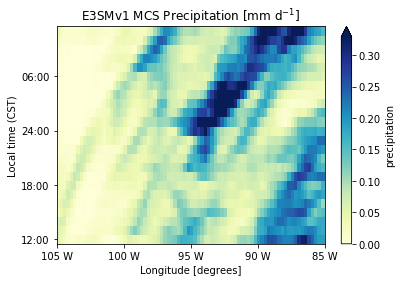

In [28]:
p = da2.assign_coords(hour=local_time).plot(x='lon', y='hour', cmap=plt.cm.YlGnBu, robust=True)
p.axes.set_title('E3SMv1 MCS Precipitation [mm d$^{-1}$]');
plt.yticks(ticks=[-12, -6, 0, 6], labels=['12:00', '18:00', '24:00', '06:00']);
p.axes.set_ylabel('Local time (CST)')
plt.xticks(ticks=[255, 260, 265, 270, 275], labels=['105 W', '100 W', '95 W', '90 W', '85 W'])

In [32]:
ds = xr.concat([da, da2], dim=pd.Index(['E3SM-MMF', 'E3SMv1'], name='model'))

Text(0.5, 1.05, 'Mean Diurnal Cycle of Central US Warm-season MCS Precipitation')

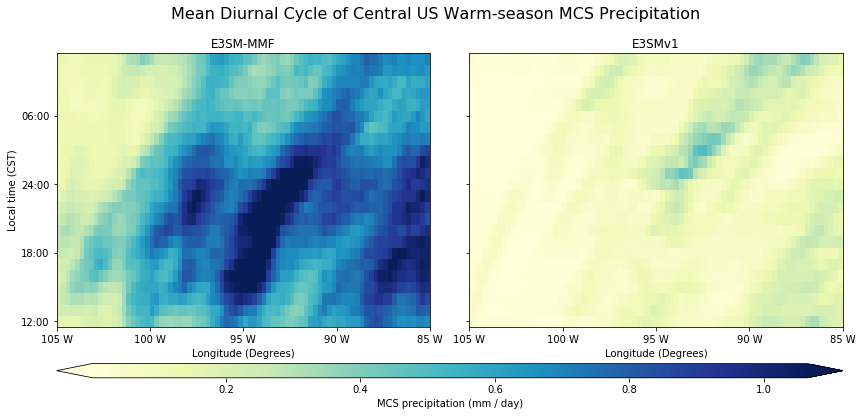

In [33]:
p = ds.assign_coords(hour=local_time).plot(x='lon', y='hour', col='model', cmap=plt.cm.YlGnBu, robust=True, figsize=(12, 6), 
                                       cbar_kwargs={'orientation': 'horizontal', 'pad': 0.1, 'aspect': 50,
                                                    'label': 'MCS precipitation (mm / day)'})
models = ['E3SM-MMF', 'E3SMv1']
for i, ax in enumerate(p.axes.flat):
    ax.set_title(models[i])
    if i == 0:
        plt.yticks(ticks=[-12, -6, 0, 6], labels=['12:00', '18:00', '24:00', '06:00']);
        ax.set_ylabel('Local time (CST)')
    else:
        plt.yticks(ticks=[-12, -6, 0, 6]);
    plt.xticks(ticks=[255, 260, 265, 270, 275], labels=['105 W', '100 W', '95 W', '90 W', '85 W'])
    ax.set_xlabel('Longitude (Degrees)')
p.fig.suptitle('Mean Diurnal Cycle of Central US Warm-season MCS Precipitation', y=1.05, fontsize=16)

In [ ]:
# need to shuffle the time to plot from 12:00 to 12:00 with 24:00 in middle
utc_offset = -6
dat = da.values  # numpy array, shape = (local_time, lon)
np.vstack(np.vsplit(dat,[24 + utc_offset])[::-1])
local_time = da.hour - 12  # hour from -12 to 24 (aka 0) to 12

# OMEGA500

In [3]:
ds_mmf = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science/monthly_hist/clim_rgr/0002-0007/earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m_[DMJS]??_climo.nc',
                           concat_dim='time')
ds_e3sm = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science_e3sm/clim_rgr/0001-0001/earlyscience.FC5AV1C-H01A.ne120.E3SM.20190329_[DMJS]??_climo.nc',
                            concat_dim='time')

In [ ]:
def preprocess_fun(ds):
    return name[:-9]

In [5]:
ds_e3sm.time

<xarray.DataArray 'time' (time: 4)>
array([cftime.DatetimeNoLeap(1, 6, 1, 16, 0, 0, 0, 5, 152),
       cftime.DatetimeNoLeap(1, 8, 1, 0, 0, 0, 0, 3, 213),
       cftime.DatetimeNoLeap(1, 5, 1, 8, 0, 0, 0, 2, 121),
       cftime.DatetimeNoLeap(1, 10, 31, 16, 0, 0, 0, 3, 304)], dtype=object)
Coordinates:
  * time     (time) object 0001-06-01 16:00:00 ... 0001-10-31 16:00:00
Attributes:
    long_name:     time
    climatology:   climatology_bounds
    cell_methods:  time: mean within years time: mean over years

In [6]:
ds = xr.open_dataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science/monthly_hist/clim_rgr/0002-0007/earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m_DJF_climo.nc')

In [8]:
ds_mmf.attrs

OrderedDict([('ne', 120),
             ('np', 4),
             ('Conventions', 'CF-1.0'),
             ('source', 'CAM'),
             ('case',
              'earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m.20190329'),
             ('title', 'UNSET'),
             ('logname', 'crjones'),
             ('host', ''),
             ('Version', '$Name$'),
             ('revision_Id', '$Id$'),
             ('initial_file',
              'earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m.20190327.cam.i.0001-11-01-00000.nc'),
             ('topography_file',
              '/gpfs/alpine/world-shared/csc190/e3sm/cesm/inputdata/atm/cam/topo/USGS-gtopo30_ne120np4_16xdel2-PFC-consistentSGH.nc'),
             ('time_period_freq', 'month_1'),
             ('history',
              "Wed May 15 09:55:15 2019: ncks -t 2 -O --no_tmp_fl --dfl_lvl=0 --hdr_pad=10000 --map /global/homes/z/zender/data/maps/map_ne120np4_to_cmip6_180x360_aave.20181001.nc /global/project/projectdirs/m3312/crjones/e3sm/early_science/m